# Prepare tensorflow-model-optimization

In [1]:
! pip uninstall -y tensorflow
! pip uninstall -y tf-nightly
! pip install -U tensorflow-gpu==1.14.0

! pip install tensorflow-model-optimization

Uninstalling tensorflow-2.2.0rc1:
  Successfully uninstalled tensorflow-2.2.0rc1
     |████████████████████████████████| 377.0MB 42kB/s 
     |████████████████████████████████| 3.2MB 49.6MB/s 
     |████████████████████████████████| 491kB 57.4MB/s 
  Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
     |████████████████████████████████| 102kB 3.3MB/s 


In [1]:
%load_ext tensorboard
import tensorboard
import tensorflow as tf
tf.enable_eager_execution()

import tempfile
import zipfile
import os

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

#Download dataset from Google Drive

In [2]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# https://drive.google.com/open?id=1Wz2xqSZSjLDzXXTLdkf6zyTUUcBopn3i
download = drive.CreateFile({'id': '1Wz2xqSZSjLDzXXTLdkf6zyTUUcBopn3i'})
download.GetContentFile('avocado_dataset_w64.hdf5')

# Read Dataset

In [4]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from operator import truediv
import h5py
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, cohen_kappa_score, confusion_matrix

import tensorboard
import tensorflow as tf
tf.enable_eager_execution()

import tempfile
import zipfile
import os
import cv2

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Data augmentation functions
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def add_rotation_flip(x, y):

    x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2], x.shape[3], 1))

    # Flip horizontally
    x_h = np.flip(x[:, :, :, :, :], 1)
    # Flip vertically
    x_v = np.flip(x[:, :, :, :, :], 2)
    # Flip horizontally and vertically
    x_hv = np.flip(x_h[:, :, :, :, :], 2)

    # Concatenate
    x = np.concatenate((x, x_h, x_v, x_hv))
    y = np.concatenate((y, y, y, y))

    return x, y
    
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
LOAD HDF5 FILE
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

hdf5_file = h5py.File('avocado_dataset_w64.hdf5', "r")
train_x = np.array(hdf5_file["train_img"][...])
train_y = np.array(hdf5_file["train_labels"][...])

# Average consecutive bands
img2 = np.zeros((train_x.shape[0], int(train_x.shape[1]/2), int(train_x.shape[2]/2), int(train_x.shape[3] / 2)))
for n in range(0, train_x.shape[0]):
    xt = cv2.resize(np.float32(train_x[n, :, :, :]), (32, 32), interpolation=cv2.INTER_CUBIC)
    for i in range(0, train_x.shape[3], 2):
        img2[n, :, :, int(i / 2)] = (xt[:, :, i] + xt[:, :, i + 1]) / 2.

train_x = img2

train_x, train_y = add_rotation_flip(train_x, train_y)

print(train_x.shape)

(964, 32, 32, 150, 1)


# Calculate loss after removing one spectral band

In [0]:
data = 'AVOCADO'
windowSize = train_x.shape[1]
classes = 2

tf.keras.backend.clear_session()
# Load trained pruned network
#loaded_model = tf.keras.models.load_model("Kochia_hyper3DNet_pruned.h5")

# Load model without pruning
loaded_model = tf.keras.models.load_model("weights-hyper3dnetAVOCADO1-best_3layers_4filters.h5")

loaded_model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer='adadelta',
        metrics=['accuracy'])

In [14]:
import pickle
from tensorflow_model_optimization.sparsity import keras as sparsity

windowSize = train_x.shape[1]
classes = 2
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

epochs = 8
batch_size = 32;
num_train_samples = train_x.shape[0]
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs

data = 'AVOCADO'
SA = np.zeros((10, train_x.shape[3],))
ntrain = 1
for train, test in kfold.split(train_x, train_y):

    loaded_model.load_weights("weights-hyper3dnet" + data + str(ntrain) + "-best_3layers_4filters.h5")
    loaded_model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer='adadelta',
        metrics=['accuracy'])

    ytest = train_y[test] 
    ypred1 = loaded_model.predict(train_x[test])
    ypred1 = ypred1.round()
    loss1 = tf.keras.losses.binary_crossentropy(ytest, ypred1)
    print("Fold:" + str(ntrain) +" , original accuracy: " + str(np.sum(ypred1.transpose()==ytest)/len(ytest)))
    for nchannel in range(0, train_x.shape[3]):
      xtest = train_x[test].copy()
      xtest[:, :, :, nchannel, :] = np.zeros((train_x[test].shape[0], train_x.shape[1], train_x.shape[2], 1))
      ypred2 = loaded_model.predict(xtest)
      ypred2 = ypred2.round()
      loss2 = tf.keras.losses.binary_crossentropy(ytest, ypred2)
      print("Analyzing channel " +str(nchannel) + ": " + str(np.sum(ypred2.transpose()==ytest)/len(ytest)))
      SA[ntrain-1][nchannel] = np.sum(abs(loss2 - loss1))

    with open('SA_fold_pruning'+str(ntrain), 'wb') as f:
      pickle.dump(SA[ntrain-1], f)

    ntrain += 1;

Fold:1 , original accuracy: 1.0
Analyzing channel 0: 0.8762886597938144
Analyzing channel 1: 1.0
Analyzing channel 2: 0.979381443298969
Analyzing channel 3: 1.0
Analyzing channel 4: 1.0
Analyzing channel 5: 1.0
Analyzing channel 6: 0.9690721649484536
Analyzing channel 7: 1.0
Analyzing channel 8: 1.0
Analyzing channel 9: 1.0
Analyzing channel 10: 1.0
Analyzing channel 11: 0.9690721649484536
Analyzing channel 12: 0.9896907216494846
Analyzing channel 13: 0.9896907216494846
Analyzing channel 14: 0.9896907216494846
Analyzing channel 15: 0.9896907216494846
Analyzing channel 16: 0.979381443298969
Analyzing channel 17: 1.0
Analyzing channel 18: 1.0
Analyzing channel 19: 1.0
Analyzing channel 20: 0.7422680412371134
Analyzing channel 21: 0.845360824742268
Analyzing channel 22: 0.6185567010309279
Analyzing channel 23: 0.979381443298969
Analyzing channel 24: 0.7010309278350515
Analyzing channel 25: 0.9175257731958762
Analyzing channel 26: 0.9278350515463918
Analyzing channel 27: 0.9072164948453608

No handles with labels found to put in legend.


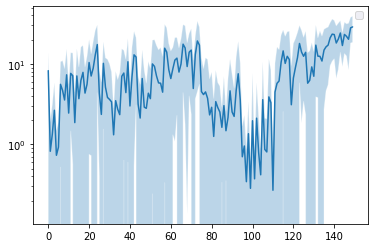

In [15]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

means = np.mean(SA, axis=0)
stds = np.std(SA, axis=0)

fig, ax = plt.subplots()
clrs = sns.color_palette()
with sns.axes_style("darkgrid"):
    epochs = list(range(150))
    
    ax.plot(epochs, means, c=clrs[0])
    ax.fill_between(epochs, means-stds, means+stds ,alpha=0.3, facecolor=clrs[0])
    ax.legend()
    ax.set_yscale('log')

plt.savefig('Bands_importance_plot_Avocado_hyper3dnet_crossvalidation_nopruning.png', dpi=1200)



Printing saliency and spectral band
Spectral band: 149	Saliency: 28.811133003234865
Spectral band: 148	Saliency: 28.033863687515257
Spectral band: 143	Saliency: 24.179373693466186
Spectral band: 139	Saliency: 23.408323955535888
Spectral band: 145	Saliency: 23.221054792404175
Spectral band: 140	Saliency: 23.148739719390868
Spectral band: 146	Saliency: 22.00699915885925
Spectral band: 138	Saliency: 21.057663488388062
Spectral band: 142	Saliency: 20.33495044708252
Spectral band: 147	Saliency: 20.21211442947388
Spectral band: 73	Saliency: 19.276685523986817
Spectral band: 141	Saliency: 18.165143060684205
Spectral band: 123	Saliency: 17.925887441635133
Spectral band: 66	Saliency: 17.5689208984375
Spectral band: 24	Saliency: 17.37908763885498
Spectral band: 137	Saliency: 17.103030681610107
Spectral band: 74	Saliency: 17.095530128479005
Spectral band: 131	Saliency: 17.095527601242065
Spectral band: 144	Saliency: 16.910637283325194
Spectral band: 136	Saliency: 16.287874221801758
Spectral ban

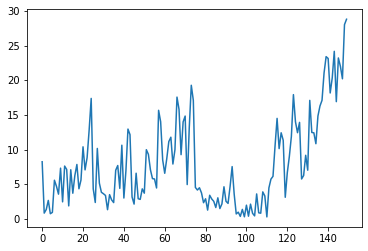

In [16]:
list_importance = list(zip(means, range(0, 150)))
sortedlist = sorted(list_importance, key = lambda x: x[0], reverse=True)
print('\n\nPrinting saliency and spectral band')
for x in sortedlist: 
    print("Spectral band: " + str(x[1]) + "\tSaliency: " + str(x[0])) 

import matplotlib.pyplot as plt
plt.plot(means)
plt.savefig('Bands_importance_MEANS_plot_Avocado_hyper3dnet_crossvalidation_nopruning.png', dpi=1200)

0.8051343194416055
0.8099213838929634


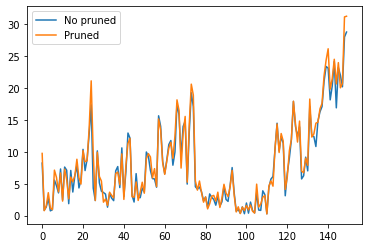

In [17]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

SA2 = np.zeros((10, 150,))

for i in range(0, 10):
      with open('SA_fold_pruning' + str(i + 1), 'rb') as f:
          SA2[i][:] = pickle.load(f)

means2 = np.mean(SA2, axis=0)
stds2 = np.std(SA2, axis=0)

import matplotlib.pyplot as plt
l1, = plt.plot(means, label='No pruned')
l2, = plt.plot(means2, label='Pruned')
plt.legend(handles=[l1, l2])
plt.savefig('Bands_importance_MEANS_plot_Avocado_hyper3dnet_crossvalidation_comparison.png', dpi=1200)

coef_variation1 = np.std(means)/np.mean(means)
print(coef_variation1)
coef_variation2 = np.std(means2)/np.mean(means2)
print(coef_variation2)